data: kaggle
https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification/data/code


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [28]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [29]:
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [31]:
# xoá cột Unnamed:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [32]:
# đếm nhãn:
df['label'].value_counts()

,count
label,
1,37106
0,35028


- số lượng nhãn giữa 1 và 0 cân bằng, không có sự chênh lệch nhãn

In [33]:
# kiểm tra missing data:
df.isnull().sum()

,0
title,558
text,39
label,0


In [34]:
# hiển thị dòng thiếu:
df[df.isnull().any(axis=1)]

,title,text,label
1,NaN,Did they post their votes for Hillary already?,1
43,NaN,True. Hillary needs a distraction and what bet...,1
162,NaN,All eyes on Electoral delegates. The People kn...,1
185,NaN,Cool,1
269,NaN,A leading US senator: US Supporting War in Syr...,1
...,...,...,...
71484,NaN,Another Arab supremacist masturbation fantasy....,1
71521,NaN,I'm sure they drastically changed accounting m...,1
71540,NaN,It's easy to imagine Obama or Kerry pissing hi...,1
71570,NaN,Ever since the powers to be assassinated JFK A...,1


- thay nan bằng chuỗi dữ liệu trống vì: Chuỗi rỗng '' được hiểu là “không có nội dung”, nhưng vẫn là dữ liệu hợp lệ. Nó giúp các bước tiền xử lý (như tokenization, vector hóa TF-IDF, embedding, BERT tokenizer, v.v.) không bị lỗi.
- => Chuỗi rỗng đôi khi là tín hiệu chứ không phải lỗi dữ liệu.

# Tiền xử lý dữ liệu

In [35]:
# chuyển giá trị nan thành chuỗi dữ liệu trống " "
df = df.fillna('')
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [36]:
# gộp văn bản:  Tạo cột content = title + text

df['content'] = df['title'] + ' ' + df['text']


In [37]:
# Tải tài nguyên NLTK
for pkg in ['stopwords', 'wordnet', 'omw-1.4']:
    try:
        nltk.data.find(f'corpora/{pkg}')
    except LookupError:
        nltk.download(pkg)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Hàm làm sạch văn bản
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+', ' ', text)  # bỏ link, tag
    text = re.sub(r'[^a-z0-9\s]', ' ', text)              # chỉ giữ lại chữ và số
    text = re.sub(r'\s+', ' ', text).strip()              # loại bỏ khoảng trắng dư
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Áp dụng
df['clean_text'] = df['content'].apply(clean_text)

# Loại bỏ dòng trống
df = df[df['clean_text'].str.strip() != ''].copy()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [38]:
# Biến độc lập và phụ thuộc
X = df['clean_text'].values
y = df['label'].values

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Thông tin
print("Train size:", len(X_train))
print("Test size :", len(X_test))


Train size: 57689
Test size : 14423


In [39]:
# Các siêu tham số
max_words = 10000    # Số lượng từ tối đa trong vocab
max_len = 200        # Độ dài chuỗi tối đa
embedding_dim = 100  # Kích thước vector embedding

# Tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Chuyển văn bản thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding cho các chuỗi có độ dài khác nhau
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Dữ liệu sau tokenizing và padding:", X_train_pad.shape)


Dữ liệu sau tokenizing và padding: (57689, 200)


In [40]:
import tensorflow as tf


In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    verbose=1
)


Epoch 1/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.6645 - loss: 0.6212 - val_accuracy: 0.8444 - val_loss: 0.4174
Epoch 2/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.7901 - loss: 0.4660 - val_accuracy: 0.8631 - val_loss: 0.3644
Epoch 3/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8367 - loss: 0.4009 - val_accuracy: 0.6668 - val_loss: 0.6213
Epoch 4/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8381 - loss: 0.3874 - val_accuracy: 0.7537 - val_loss: 0.5351
Epoch 5/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8408 - loss: 0.3758 - val_accuracy: 0.9203 - val_loss: 0.1987
Epoch 6/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9454 - loss: 0.1591 - val_accuracy: 0.9518 - val_loss: 0.1431
Epoch 7/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9699 - loss: 0.0951 - val_accuracy: 0.9560 - val_loss: 0.1329
Epoch 8/10
902/902 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9758 - loss: 0.0760 - 

451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9582 - loss: 0.1542

 Độ chính xác trên tập kiểm thử: 0.9583


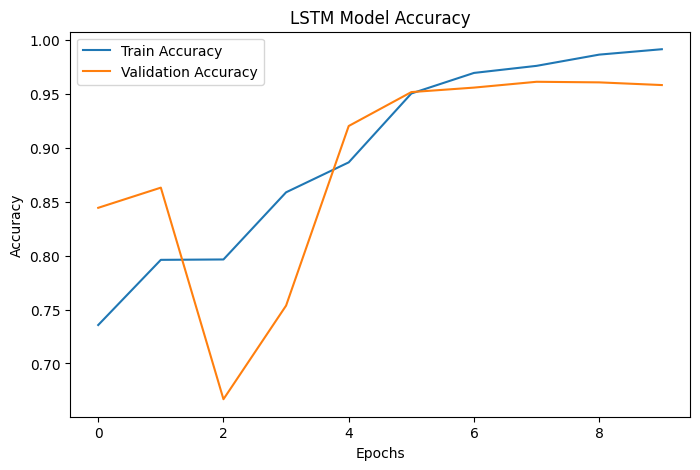

In [43]:
# Độ chính xác
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\n Độ chính xác trên tập kiểm thử: {acc:.4f}")

# Biểu đồ huấn luyện
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
